# Red Neuronal para Análisis de sentimientos
En el jupyter notebook se puede ver la construcción de un modelo SVM que predice el sentimiento de un comentario de redes sociales para dos productos ecuatorianos. Incluye la limpieza de datos, su preprocesamiento, preparación, construcción del modelo y evaluación del modelo.

In [2]:
import pandas as pd     #permite manipular datos
import numpy as np      #permite manipular números y matrices
import seaborn as sns   #permite manipulacion mediante graficos
sns.set_style("dark")   
import re               #proporciona coincidir con expresiones regulares
import string           #permite trabajos con formatos str
from string import punctuation
import nltk             #permite la utilzación de natural lenguaje toolkit
from nltk.corpus import stopwords  #bolsa de palabras stopwords
#nltk.download('stopwords')

from sklearn.ensemble import RandomForestClassifier   #clasificador
from sklearn.neighbors import KNeighborsClassifier    #clasificador
 
import matplotlib.pyplot as plt                               #librería de gráficos
from sklearn.model_selection import train_test_split         #permite entrenamiento de la data
from sklearn.feature_extraction.text import CountVectorizer  #convertir token a vector
from sklearn.feature_extraction.text import TfidfTransformer #utilizado para normalizar matrices 

import tensorflow as tf                                        #manejo con redes neuronales 
from tensorflow.keras.models import Sequential                 #manejo con redes neuronales 
from tensorflow.keras.layers import Dense, Activation, Dropout #manejo con redes neuronales 
from tensorflow.keras.callbacks import EarlyStopping           #manejo con redes neuronales 
import tensorflow.keras.metrics                                #manejo con redes neuronales 

from sklearn.model_selection import GridSearchCV               #optimizacion de hiperparámetros
#from keras.models import Sequential, Model                     #manejo con redes neuronales 
from keras.layers import Activation, Dense, Dropout            #manejo con redes neuronales 
from keras.wrappers.scikit_learn import KerasClassifier        #manejo con redes neuronales  

import pickle                                       #permite trabajo de datos como bytes
from sklearn.preprocessing import LabelBinarizer    #permite trabajar desde un cjto Y a matriz
import sklearn.datasets as skds                     #permite cargar archivos de texto
from pathlib import Path                            #permite trabajar con rutas concretas
import itertools                                    #permite crear iteradores para  bucles eficientes
from sklearn.metrics import confusion_matrix        #permite trabajar con matriz de confusión
# For reproducibility
np.random.seed(1237)                                #fija numeros aleatorios

In [3]:
pip install keras #biblioteca que permite la utilizacion de redes neuronales

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#biblioteca'


In [4]:

data = pd.read_excel('Yelp.xlsx')  #Cargar los datos
data.head()

,content,Polarity_Rating
0,Guau ... Me encantó este lugar.,Positive
1,La corteza no es buena.,Negative
2,No es sabroso y la textura era simplemente des...,Negative
3,Pasé por allí durante el feriado bancario de f...,Positive
4,"La selección del menú era excelente, al igual ...",Positive


In [7]:
df2 = pd.DataFrame()
df2 = data
#df2 = data.drop(['tweetid', 'user','value','country'], axis=1)
#df2.dropna(inplace=True)
df2.head()

,content,Polarity_Rating
0,Guau ... Me encantó este lugar.,Positive
1,La corteza no es buena.,Negative
2,No es sabroso y la textura era simplemente des...,Negative
3,Pasé por allí durante el feriado bancario de f...,Positive
4,"La selección del menú era excelente, al igual ...",Positive


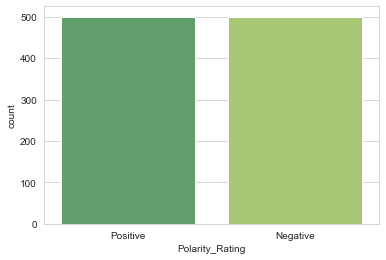

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='Polarity_Rating',data=df2, palette='summer')

In [9]:
print(df2['Polarity_Rating'].value_counts())

Negative    500
Positive    500
Name: Polarity_Rating, dtype: int64


#2 Preprocesamiento

In [10]:
df2['content'] = df2['content'].apply(lambda x: re.split('https:\/\/.*', str(x))[0]) #elimina url
df2['content'] = df2['content'].apply(lambda x: re.split('\d+', str(x))[0]) #elimina palabras con numeros

In [11]:
#elimina palabras con letras repetidas
def conti_rep_char(str1):
    tchr = str1.group(0)
    if len(tchr) > 1:
      return tchr[0:1]
      
def check_unique_char(rep, sent_text):
    
    convert = re.sub(r'(\w)\1+', rep,sent_text)
      
    #regresa la palabra convertida
    return convert
  
df2['content'] = df2['content'].apply(lambda x : check_unique_char(conti_rep_char,x))
df2

,content,Polarity_Rating
0,Guau ... Me encantó este lugar.,Positive
1,La corteza no es buena.,Negative
2,No es sabroso y la textura era simplemente des...,Negative
3,Pasé por alí durante el feriado bancario de fi...,Positive
4,"La seleción del menú era excelente, al igual q...",Positive
...,...,...
995,Creo que la comida debería tener sabor y textu...,Negative
996,El apetito desapareció instantáneamente.,Negative
997,"En general, no me impresionó y no volvería.",Negative
998,"Toda la experiencia fue decepcionante, y creo ...",Negative


In [12]:
import emoji 

def get_mentions_processing(text):
    return " ".join(filter(lambda x:x[0]!='@', text.split())) #no mentions

def get_hashtags_processing(text):
    return " ".join(filter(lambda x:x[0]!='#', text.split())) #no hashtags

def get_emojis_processing(text):
    return str(emoji.demojize(text,language='es')).replace(":"," ") #cambia emojis a texto

def get_less3words_processing(text):
    return ' '.join([word for word in text.split() if len(word)>2]) #elimina palabras con menos de 3 caracteres

def get_text_processing(text):
    stpword = stopwords.words('spanish')
    non_words = list(punctuation) #considera ¿ y ¡
    non_words.extend(['¿', '¡'])
    no_punctuation = [char for char in text if char not in non_words] #elimina puntuacion
    no_punctuation = ''.join(no_punctuation).lower() #convierte en minuscula
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword]) #elimina stopwords

def normalize(s): #elimina las vocales con tilde
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

In [13]:
df2 = df2.sample(frac=1).reset_index(drop=True)
df3 = pd.DataFrame()
df3 = df2
df3['content'] = df2['content']
df3['Content_Review'] = df2['content'].apply(get_mentions_processing)
df3['Content_Review1'] = df3['Content_Review'].apply(get_hashtags_processing)
df3['Content_Review2'] = df3['Content_Review1'].apply(get_emojis_processing)
df3['Content_Review3'] = df3['Content_Review2'].apply(get_text_processing)
df3['Content_Review4'] = df3['Content_Review3'].apply(get_less3words_processing)
df3['Content_Review5'] = df3['Content_Review4'].apply(normalize)
df3

,content,Polarity_Rating,Content_Review,Content_Review1,Content_Review2,Content_Review3,Content_Review4,Content_Review5
0,El mejor lugar para desayunar en Las Vegas (so...,Positive,El mejor lugar para desayunar en Las Vegas (so...,El mejor lugar para desayunar en Las Vegas (so...,El mejor lugar para desayunar en Las Vegas (so...,mejor lugar desayunar vegas solo echa vistazo ...,mejor lugar desayunar vegas solo echa vistazo ...,mejor lugar desayunar vegas solo echa vistazo ...
1,Mi bebida nunca estuvo vacía e hizo algunas su...,Positive,Mi bebida nunca estuvo vacía e hizo algunas su...,Mi bebida nunca estuvo vacía e hizo algunas su...,Mi bebida nunca estuvo vacía e hizo algunas su...,bebida nunca vacía hizo sugerencias menú realm...,bebida nunca vacía hizo sugerencias menú realm...,bebida nunca vacia hizo sugerencias menu realm...
2,"En general, no me impresionó mucho Noca.",Negative,"En general, no me impresionó mucho Noca.","En general, no me impresionó mucho Noca.","En general, no me impresionó mucho Noca.",general impresionó noca,general impresionó noca,general impresiono noca
3,La administración es de mala educación.,Negative,La administración es de mala educación.,La administración es de mala educación.,La administración es de mala educación.,administración mala educación,administración mala educación,administracion mala educacion
4,"La comida está a la par con Deny's, lo que qui...",Negative,"La comida está a la par con Deny's, lo que qui...","La comida está a la par con Deny's, lo que qui...","La comida está a la par con Deny's, lo que qui...",comida par denys quiere decir bueno,comida par denys quiere decir bueno,comida par denys quiere decir bueno
...,...,...,...,...,...,...,...,...
995,La mejor de las suertes para la nueva administ...,Negative,La mejor de las suertes para la nueva administ...,La mejor de las suertes para la nueva administ...,La mejor de las suertes para la nueva administ...,mejor suertes nueva administración mala educac...,mejor suertes nueva administración mala educac...,mejor suertes nueva administracion mala educac...
996,El restaurante está muy limpio y tiene un ambi...,Positive,El restaurante está muy limpio y tiene un ambi...,El restaurante está muy limpio y tiene un ambi...,El restaurante está muy limpio y tiene un ambi...,restaurante limpio ambiente familiar,restaurante limpio ambiente familiar,restaurante limpio ambiente familiar
997,"Nos sentamos bastante rápido, pero terminamos ...",Negative,"Nos sentamos bastante rápido, pero terminamos ...","Nos sentamos bastante rápido, pero terminamos ...","Nos sentamos bastante rápido, pero terminamos ...",sentamos bastante rápido terminamos esperando,sentamos bastante rápido terminamos esperando,sentamos bastante rapido terminamos esperando
998,¡A este lugar le faltaba estilo!,Negative,¡A este lugar le faltaba estilo!,¡A este lugar le faltaba estilo!,¡A este lugar le faltaba estilo!,lugar faltaba estilo,lugar faltaba estilo,lugar faltaba estilo


In [14]:
df4 = pd.DataFrame()
df4 = df3
df4 = df3[['Content_Review5', 'Polarity_Rating']]
print(df4.shape)
df4.head()

(1000, 2)


,Content_Review5,Polarity_Rating
0,mejor lugar desayunar vegas solo echa vistazo ...,Positive
1,bebida nunca vacia hizo sugerencias menu realm...,Positive
2,general impresiono noca,Negative
3,administracion mala educacion,Negative
4,comida par denys quiere decir bueno,Negative


In [15]:
# Elimino registros con Answers NaN
df4['Content_Review5'].replace('', np.nan, inplace=True) # Reemplazo los registros vacíos con NaN
print(df4['Content_Review5'].isna().sum()) 
df4 = df4.dropna(axis=0, subset=['Content_Review5'])
print(df4.shape)
df4

6
(994, 2)


C:\Users\gpulg\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,Content_Review5,Polarity_Rating
0,mejor lugar desayunar vegas solo echa vistazo ...,Positive
1,bebida nunca vacia hizo sugerencias menu realm...,Positive
2,general impresiono noca,Negative
3,administracion mala educacion,Negative
4,comida par denys quiere decir bueno,Negative
...,...,...
995,mejor suertes nueva administracion mala educac...,Negative
996,restaurante limpio ambiente familiar,Positive
997,sentamos bastante rapido terminamos esperando,Negative
998,lugar faltaba estilo,Negative


In [16]:
X=df4['Content_Review5'].values #se definen como valores
y=df4['Polarity_Rating'].values #se definen como valores

#Partición de la base entre testeo y entrenamiento

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, train_size=0.70, random_state=42)

In [17]:
print(X.shape)
print(y.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(994,)
(994,)
(695,)
(299,)
(695,)
(299,)


In [18]:
y_test

array(['Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Negative', 'Negative', 'Negative',
       'Negative', 'Positive', 'Negative', 'Positive', 'Positive',
       'Negative', 'Negative', 'Positive', 'Negative', 'Positive',
       'Negative', 'Negative', 'Negative', 'Positive', 'Positive',
       'Positive', 'Positive', 'Negative', 'Positive', 'Positive',
       'Negative', 'Positive', 'Negative', 'Negative', 'Positive',
       'Positive', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Positive', 'Negative', 'Negative',
       'Positive', 'Negative', 'Positive', 'Negative', 'Negative',
       'Positive', 'Positive', 'Negative', 'Positive', 'Negative',
       'Negative', 'Positive', 'Negative', 'Negative', 'Negative',
       'Negative', 'Positive', 'Negative', 'Negative', 'Negative',
       'Positive', 'Negative', 'Negative', 'Negative', 'Positive',
       'Positive', 'Negative', 'Negative', 'Negative', 'Negati

In [19]:
vect1 = CountVectorizer(min_df=2,ngram_range=(1,1)) #transformo los X (values) en vectores 
X_train = vect1.fit_transform(X_train) 
X_test = vect1.transform(X_test)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(695, 550)
(299, 550)
(695,)
(299,)


In [21]:
encoder = LabelBinarizer()  #Transformo los Y (values) en vectores
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_train

array([[1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
    

In [22]:
train_size=int(len(df4) * .7)              #permite la visualización más adelante en la matriz de confusión
test_tags=df4['Polarity_Rating'][train_size:] #permite la visualización más adelante en la matriz de confusión

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(695, 550)
(299, 550)
(695, 1)
(299, 1)


In [24]:
tfidf = TfidfTransformer(smooth_idf=True,use_idf=True) #Entrega ponderación de importancia a palabras más "importantes" (frecuentes)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

In [25]:
# print idf values 
df_idf = pd.DataFrame(tfidf.idf_, index=vect1.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
comida,3.091002
lugar,3.150901
servicio,3.418215
aqui,3.807680
tan,4.213145
...,...
mantuvo,6.446737
mantequila,6.446737
mama,6.446737
masticable,6.446737


In [26]:
X_train.shape

(695, 550)

In [27]:
y_train.shape

(695, 1)

In [71]:
#4.1 red aplicada
from keras.constraints import maxnorm
from tensorflow import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = Sequential()                                         #Se define estructura de la red capa por capa
model.add(Dense(units=1500, kernel_initializer='uniform', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.9))
model.add(Dense(units=1200,kernel_initializer='uniform', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.9))
model.add(Dense(units=1,kernel_initializer='zero', activation='softmax'))

#optimizer=tf.keras.optimizers.Adamax(0.001)
#model.compile(optimizer= 'adam' , loss= keras.losses.binary_crossentropy, metrics=['accuracy'])
model.compile(optimizer = 'adam',loss='categorical_crossentropy', metrics=METRICS)  #Se compila la red en conjunto a su optimizador


In [72]:
history = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=0.3, verbose=2)

Epoch 1/100
2/2 - 7s - loss: 0.0000e+00 - tp: 236.0000 - fp: 250.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4856 - recall: 1.0000 - auc: 0.5000 - prc: 0.4856 - val_loss: 0.0000e+00 - val_tp: 98.0000 - val_fp: 111.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.4689 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.4689
Epoch 2/100
2/2 - 0s - loss: 0.0000e+00 - tp: 236.0000 - fp: 250.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4856 - recall: 1.0000 - auc: 0.5000 - prc: 0.4856 - val_loss: 0.0000e+00 - val_tp: 98.0000 - val_fp: 111.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.4689 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.4689
Epoch 3/100
2/2 - 0s - loss: 0.0000e+00 - tp: 236.0000 - fp: 250.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4856 - recall: 1.0000 - auc: 0.5000 - prc: 0.4856 - val_loss: 0.0000e+00 -

Epoch 22/100
2/2 - 0s - loss: 0.0000e+00 - tp: 236.0000 - fp: 250.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4856 - recall: 1.0000 - auc: 0.5000 - prc: 0.4856 - val_loss: 0.0000e+00 - val_tp: 98.0000 - val_fp: 111.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.4689 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.4689
Epoch 23/100
2/2 - 0s - loss: 0.0000e+00 - tp: 236.0000 - fp: 250.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4856 - recall: 1.0000 - auc: 0.5000 - prc: 0.4856 - val_loss: 0.0000e+00 - val_tp: 98.0000 - val_fp: 111.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.4689 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.4689
Epoch 24/100
2/2 - 0s - loss: 0.0000e+00 - tp: 236.0000 - fp: 250.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4856 - recall: 1.0000 - auc: 0.5000 - prc: 0.4856 - val_loss: 0.0000e+0

Epoch 43/100
2/2 - 0s - loss: 0.0000e+00 - tp: 236.0000 - fp: 250.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4856 - recall: 1.0000 - auc: 0.5000 - prc: 0.4856 - val_loss: 0.0000e+00 - val_tp: 98.0000 - val_fp: 111.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.4689 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.4689
Epoch 44/100
2/2 - 0s - loss: 0.0000e+00 - tp: 236.0000 - fp: 250.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4856 - recall: 1.0000 - auc: 0.5000 - prc: 0.4856 - val_loss: 0.0000e+00 - val_tp: 98.0000 - val_fp: 111.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.4689 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.4689
Epoch 45/100
2/2 - 0s - loss: 0.0000e+00 - tp: 236.0000 - fp: 250.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4856 - recall: 1.0000 - auc: 0.5000 - prc: 0.4856 - val_loss: 0.0000e+0

Epoch 64/100
2/2 - 0s - loss: 0.0000e+00 - tp: 236.0000 - fp: 250.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4856 - recall: 1.0000 - auc: 0.5000 - prc: 0.4856 - val_loss: 0.0000e+00 - val_tp: 98.0000 - val_fp: 111.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.4689 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.4689
Epoch 65/100
2/2 - 0s - loss: 0.0000e+00 - tp: 236.0000 - fp: 250.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4856 - recall: 1.0000 - auc: 0.5000 - prc: 0.4856 - val_loss: 0.0000e+00 - val_tp: 98.0000 - val_fp: 111.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.4689 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.4689
Epoch 66/100
2/2 - 0s - loss: 0.0000e+00 - tp: 236.0000 - fp: 250.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4856 - recall: 1.0000 - auc: 0.5000 - prc: 0.4856 - val_loss: 0.0000e+0

Epoch 85/100
2/2 - 0s - loss: 0.0000e+00 - tp: 236.0000 - fp: 250.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4856 - recall: 1.0000 - auc: 0.5000 - prc: 0.4856 - val_loss: 0.0000e+00 - val_tp: 98.0000 - val_fp: 111.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.4689 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.4689
Epoch 86/100
2/2 - 0s - loss: 0.0000e+00 - tp: 236.0000 - fp: 250.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4856 - recall: 1.0000 - auc: 0.5000 - prc: 0.4856 - val_loss: 0.0000e+00 - val_tp: 98.0000 - val_fp: 111.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.4689 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.4689
Epoch 87/100
2/2 - 0s - loss: 0.0000e+00 - tp: 236.0000 - fp: 250.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4856 - recall: 1.0000 - auc: 0.5000 - prc: 0.4856 - val_loss: 0.0000e+0

In [73]:
score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)  #Evaluar el modelo.

#print('Test accuracy:', score[1])

5/5 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - tp: 162.0000 - fp: 137.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.5418 - recall: 1.0000 - auc: 0.5000 - prc: 0.5418


In [76]:
#OPTIMIZER ALGORITHM
# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=2398, activation='relu'))
	model.add(Dense(3, activation='hard_sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset
Xx = X_train
Yy = y_train
# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(Xx, Yy)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.724283 using {'optimizer': 'Adamax'}
0.721192 (0.009090) with: {'optimizer': 'SGD'}
0.724002 (0.001733) with: {'optimizer': 'RMSprop'}
0.579820 (0.011465) with: {'optimizer': 'Adagrad'}
0.570264 (0.021610) with: {'optimizer': 'Adadelta'}
0.671726 (0.012341) with: {'optimizer': 'Adam'}
0.724283 (0.004819) with: {'optimizer': 'Adamax'}
0.669477 (0.007188) with: {'optimizer': 'Nadam'}


In [79]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

In [81]:
# Use scikit-learn to grid search the activation function
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(activation='relu'):
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=2398, kernel_initializer='uniform', activation=activation))
	model.add(Dense(3, kernel_initializer='uniform', activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset
Xx = X_train
Yy = y_train
# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(Xx, Yy)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.703766 using {'activation': 'hard_sigmoid'}
0.699831 (0.006310) with: {'activation': 'softmax'}
0.682406 (0.006397) with: {'activation': 'softplus'}
0.667229 (0.007297) with: {'activation': 'softsign'}
0.675379 (0.003577) with: {'activation': 'relu'}
0.661046 (0.008789) with: {'activation': 'tanh'}
0.694210 (0.005167) with: {'activation': 'sigmoid'}
0.703766 (0.006757) with: {'activation': 'hard_sigmoid'}
0.663575 (0.005377) with: {'activation': 'linear'}


In [66]:
from keras.constraints import maxnorm
from tensorflow import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = Sequential()
model.add(Dense(units=1500, kernel_initializer='uniform', activation='hard_sigmoid', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(units=1200,kernel_initializer='uniform', activation='hard_sigmoid', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(units=2,kernel_initializer='zero', activation='softmax'))

#optimizer=tf.keras.optimizers.Adamax(0.001)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=METRICS)
model.compile(optimizer = 'Adamax',loss='categorical_crossentropy', metrics=METRICS)

In [67]:
history = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100


ValueError: in user code:

    C:\Users\gpulg\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\gpulg\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\gpulg\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\gpulg\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\gpulg\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\gpulg\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\gpulg\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:796 train_step
        loss = self.compiled_loss(
    C:\Users\gpulg\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\gpulg\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\gpulg\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\gpulg\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\gpulg\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:1643 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\Users\gpulg\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\gpulg\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\backend.py:4862 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\gpulg\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 2) are incompatible


In [49]:
score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)

#print('Test accuracy:', score[1])

5/5 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - tp: 162.0000 - fp: 137.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.5418 - recall: 1.0000 - auc: 0.5000 - prc: 0.5418


In [50]:
prediction = model.predict(X_test)

In [51]:
predictions = np.argmax(prediction, axis = 1)

In [52]:
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtyp

In [53]:
y_test_labels = np.argmax(y_test, axis =1)

In [54]:
y_test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtyp

In [55]:
y_train_labels = np.argmax(y_train, axis =1)
y_train_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [58]:

#from sklearn.utils import class_weight   #Estima los pesos de las clases
#weight = class_weight.compute_class_weight('balanced', np.unique(y_train_labels), y_train_labels)
#weight = {i : weight[i] for i in range(1)}
#weight

{0: 1.0}

In [60]:
num_epochs =200
batch_size = 256
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    #class_weight=weight,   #con el class_weight le digo al modelo q tenga especial atencion con la clase sobre/infra representada 
                    validation_split=0.2)

Epoch 1/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 2/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 3/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - v

Epoch 22/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 23/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 24/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 

Epoch 43/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 44/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 45/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 

Epoch 64/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 65/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 66/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 

Epoch 85/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 86/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 87/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 

Epoch 106/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 107/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 108/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+

Epoch 127/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 128/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 129/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+

Epoch 148/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 149/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 150/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+

Epoch 169/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 170/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 171/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+

Epoch 190/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 191/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+00 - val_tp: 73.0000 - val_fp: 66.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.5252 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5252
Epoch 192/200
3/3 - 0s - loss: 0.0000e+00 - tp: 261.0000 - fp: 295.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.4694 - recall: 1.0000 - auc: 0.5000 - prc: 0.4694 - val_loss: 0.0000e+

In [61]:
score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)  #Evaluar el modelo.

#print('Test accuracy:', score[1])

5/5 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - tp: 162.0000 - fp: 137.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.5418 - recall: 1.0000 - auc: 0.5000 - prc: 0.5418


In [62]:
import matplotlib as mpl
import matplotlib.pyplot as plt
def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

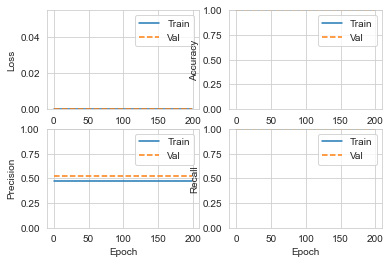

In [63]:
plot_metrics(history)

from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced' ,np.unique(y_train_labels) ,y_train_labels)
class_weight

Actual label:Positive
Predicted label: Negative
Actual label:Negative
Predicted label: Negative
Actual label:Positive
Predicted label: Negative
Actual label:Negative
Predicted label: Negative
Actual label:Negative
Predicted label: Negative
Actual label:Negative
Predicted label: Negative
Actual label:Negative
Predicted label: Negative
Actual label:Positive
Predicted label: Negative
Actual label:Positive
Predicted label: Negative
Actual label:Negative
Predicted label: Negative
Normalized confusion matrix


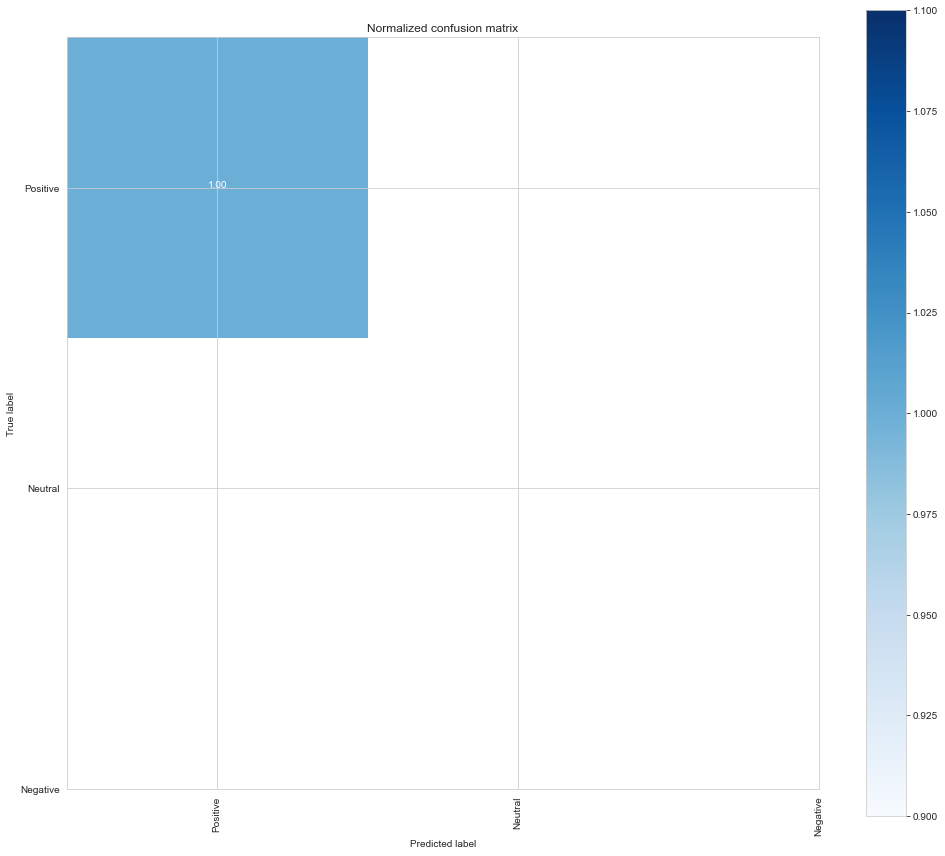

In [64]:
from sklearn.metrics import confusion_matrix
text_labels = encoder.classes_
label_names=['Positive','Neutral','Negative']

for i in range(10):
    prediction = model.predict(np.array([X_test[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    #print(test_files_names.iloc[i])
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = model.predict(X_test);
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot normalized confusion matrix

fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=True,
                      title='Normalized confusion matrix')

fig.savefig("txt_classification-smote" + str(num_epochs) + ".png", pad_inches=5.0)

In [65]:
encoder.inverse_transform(y_test)

array(['Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Negative', 'Negative', 'Negative',
       'Negative', 'Positive', 'Negative', 'Positive', 'Positive',
       'Negative', 'Negative', 'Positive', 'Negative', 'Positive',
       'Negative', 'Negative', 'Negative', 'Positive', 'Positive',
       'Positive', 'Positive', 'Negative', 'Positive', 'Positive',
       'Negative', 'Positive', 'Negative', 'Negative', 'Positive',
       'Positive', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Positive', 'Negative', 'Negative',
       'Positive', 'Negative', 'Positive', 'Negative', 'Negative',
       'Positive', 'Positive', 'Negative', 'Positive', 'Negative',
       'Negative', 'Positive', 'Negative', 'Negative', 'Negative',
       'Negative', 'Positive', 'Negative', 'Negative', 'Negative',
       'Positive', 'Negative', 'Negative', 'Negative', 'Positive',
       'Positive', 'Negative', 'Negative', 'Negative', 'Negati

***Deployment***

In [123]:
delilu= pd.read_excel(r'C:\Users\joel-\Documents\Tesis\commentsdelilu.xlsx')
delilu.head()

,id,parent_id,object_id,message,created_time,like_count,comment_count
0,253,4,5385637364812223_5389760717733221,NaN,2021-04-02 09:10:48,0.0,1.0
1,254,4,5385637364812223_5391297577579535,:D,2021-04-02 16:09:18,0.0,0.0
2,255,4,5385637364812223_5391709464205013,NaN,2021-04-02 18:27:53,1.0,1.0
3,256,4,5385637364812223_5400254766683816,🥰,2021-04-04 09:14:45,0.0,0.0
4,267,9,5260239854018642_5322553797787247,Daniela Gilces,2021-03-18 20:15:21,0.0,0.0


In [124]:
delilu.dropna(inplace=True)
delilu.head()

,id,parent_id,object_id,message,created_time,like_count,comment_count
1,254,4,5385637364812223_5391297577579535,:D,2021-04-02 16:09:18,0.0,0.0
3,256,4,5385637364812223_5400254766683816,🥰,2021-04-04 09:14:45,0.0,0.0
4,267,9,5260239854018642_5322553797787247,Daniela Gilces,2021-03-18 20:15:21,0.0,0.0
5,270,10,5260235984019029_5265073256868635,La que me gusta con delilu😈🥵😳,2021-03-05 22:58:38,0.0,1.0
6,271,10,5260235984019029_5275797155796245,Leí me vine en Lulú ._.,2021-03-08 11:55:28,0.0,1.0


In [125]:
delilu['message'] = delilu['message'].apply(lambda x: re.split('https:\/\/.*', str(x))[0]) #elimina url
delilu['message'] = delilu['message'].apply(lambda x: re.split('\d+', str(x))[0]) #elimina palabras con numeros


In [126]:
#elimina palabras con letras repetidas
def conti_rep_char(str1):
    tchr = str1.group(0)
    if len(tchr) > 1:
      return tchr[0:1]
      
def check_unique_char(rep, sent_text):
    
    convert = re.sub(r'(\w)\1+', rep,sent_text)
      
    #regresa la palabra convertida
    return convert
  
delilu['message'] = delilu['message'].apply(lambda x : check_unique_char(conti_rep_char,x))
delilu

,id,parent_id,object_id,message,created_time,like_count,comment_count
1,254,4,5385637364812223_5391297577579535,:D,2021-04-02 16:09:18,0.0,0.0
3,256,4,5385637364812223_5400254766683816,🥰,2021-04-04 09:14:45,0.0,0.0
4,267,9,5260239854018642_5322553797787247,Daniela Gilces,2021-03-18 20:15:21,0.0,0.0
5,270,10,5260235984019029_5265073256868635,La que me gusta con delilu😈🥵😳,2021-03-05 22:58:38,0.0,1.0
6,271,10,5260235984019029_5275797155796245,Leí me vine en Lulú ._.,2021-03-08 11:55:28,0.0,1.0
...,...,...,...,...,...,...,...
3896,4823,234,2130376903671635_2135123219863670,son ricas ya me compre un par,2018-06-30 23:33:16,0.0,0.0
3897,4834,239,2081255925250400_2108765545832771,note estoy en las nubes,2018-06-16 23:14:51,1.0,0.0
3898,4835,239,2081255925250400_2116303475078978,Wow👌,2018-06-20 23:58:45,0.0,0.0
3899,4840,241,2111276798914979_2121492991226693,que asco de momo,2018-06-23 15:14:10,0.0,0.0


In [127]:
delilu['message']
delilu['message'] = delilu['message'].apply(get_mentions_processing)
delilu['message']= delilu['message'].apply(get_hashtags_processing)
delilu['message'] = delilu['message'].apply(get_emojis_processing)
delilu['message'] = delilu['message'].apply(get_text_processing)
delilu['message']= delilu['message'].apply(get_less3words_processing)
delilu['message'] = delilu['message'].apply(normalize)
delilu[['message']]

,message
1,
3,carasonriendoconcorazones
4,daniela gilces
5,gusta delilu carasonriendoconcuernos caraconca...
6,lei vine lulu
...,...
3896,ricas compre par
3897,note nubes
3898,wow señaldeaprobacionconlamano
3899,asco momo


In [129]:
delilu['message'].replace('', np.nan, inplace=True) # Reemplazo los registros vacíos con NaN
print(delilu['message'].isna().sum()) 
delilu.dropna(axis=0, subset=['message'],inplace=True)
print(delilu.shape)
delilu

0
(2571, 7)


,id,parent_id,object_id,message,created_time,like_count,comment_count
3,256,4,5385637364812223_5400254766683816,carasonriendoconcorazones,2021-04-04 09:14:45,0.0,0.0
4,267,9,5260239854018642_5322553797787247,daniela gilces,2021-03-18 20:15:21,0.0,0.0
5,270,10,5260235984019029_5265073256868635,gusta delilu carasonriendoconcuernos caraconca...,2021-03-05 22:58:38,0.0,1.0
6,271,10,5260235984019029_5275797155796245,lei vine lulu,2021-03-08 11:55:28,0.0,1.0
7,272,10,5260235984019029_5275846755791285,nunca falte delilu,2021-03-08 12:09:19,0.0,0.0
...,...,...,...,...,...,...,...
3896,4823,234,2130376903671635_2135123219863670,ricas compre par,2018-06-30 23:33:16,0.0,0.0
3897,4834,239,2081255925250400_2108765545832771,note nubes,2018-06-16 23:14:51,1.0,0.0
3898,4835,239,2081255925250400_2116303475078978,wow señaldeaprobacionconlamano,2018-06-20 23:58:45,0.0,0.0
3899,4840,241,2111276798914979_2121492991226693,asco momo,2018-06-23 15:14:10,0.0,0.0


In [130]:
textos=delilu['message'].values
textos.shape


(2571,)

In [131]:
X_deploy = vect1.transform(textos)
X_deploy = tfidf.transform(X_deploy)
X_deploy = X_deploy.toarray()

In [132]:
preddelilu = model.predict(X_deploy)

In [133]:
preddelilu

array([[1.0215026e-05, 9.9987113e-01, 1.1864152e-04],
       [9.6325672e-01, 2.3513781e-02, 1.3229430e-02],
       [5.7554539e-09, 1.6162552e-02, 9.8383743e-01],
       ...,
       [1.9071965e-06, 9.8384780e-01, 1.6150311e-02],
       [9.8802060e-01, 1.1772936e-02, 2.0643907e-04],
       [1.3265784e-05, 9.9943501e-01, 5.5170699e-04]], dtype=float32)

In [134]:
sentimientos=encoder.inverse_transform(preddelilu)
sentimientos

array(['Neutral', 'Negative', 'Positive', ..., 'Neutral', 'Negative',
       'Neutral'], dtype='<U8')

In [135]:
label=pd.DataFrame(sentimientos, columns = ['label'])
label

,label
0,Neutral
1,Negative
2,Positive
3,Negative
4,Positive
...,...
2566,Positive
2567,Negative
2568,Neutral
2569,Negative


In [136]:
delilu['sentiment']=label['label']

AttributeError: 'AxesSubplot' object has no property 'fontsize'

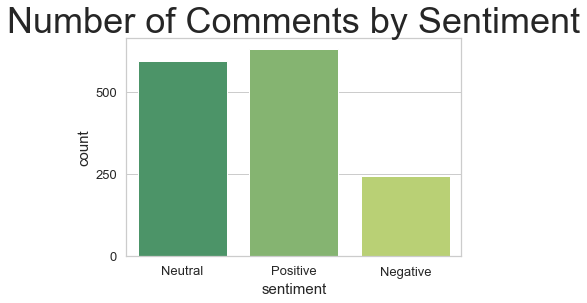

In [183]:
sns.set_style('whitegrid')
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlabel("Sentiment",fontsize=15)
plt.ylabel("Number of Comments", fontsize=15)
a=sns.countplot(x='sentiment',data=delilu, palette='summer',order = favorita['sentiment'].value_counts().index).set(title="Number of Comments by Sentiment",fontsize=20)

La favorita

In [162]:
favorita= pd.read_excel(r'C:\Users\joel-\Documents\Tesis\commentsfavorita.xlsx')
favorita.head()

,id,parent_id,object_id,message,created_time
0,2411,48,3513707055341384_3550269558351800,#CocinandoConLaFavorita mi rico encebollado d...,2020-08-12 22:03:55
1,2412,48,3513707055341384_3550280388350717,#CocinandoConLaFavorita mis ricas empanadas d...,2020-08-12 22:08:54
2,2378,48,3513707055341384_3531473420231414,#CocinandoConLaFavorita Participando con un e...,2020-08-06 12:50:22
3,2380,48,3513707055341384_3531709220207834,#Cocinandoconlafavorita un delicioso moro mix...,2020-08-06 14:27:35
4,2537,60,3376308765747881_3381054451939979,#DiaDelPadre #PapaDeLasHamburguesas #Favorita...,2020-06-14 09:50:16


In [164]:
favorita.dropna(inplace=True)
favorita.head()

,id,parent_id,object_id,message,created_time
0,2411,48,3513707055341384_3550269558351800,#CocinandoConLaFavorita mi rico encebollado d...,2020-08-12 22:03:55
1,2412,48,3513707055341384_3550280388350717,#CocinandoConLaFavorita mis ricas empanadas d...,2020-08-12 22:08:54
2,2378,48,3513707055341384_3531473420231414,#CocinandoConLaFavorita Participando con un e...,2020-08-06 12:50:22
3,2380,48,3513707055341384_3531709220207834,#Cocinandoconlafavorita un delicioso moro mix...,2020-08-06 14:27:35
4,2537,60,3376308765747881_3381054451939979,#DiaDelPadre #PapaDeLasHamburguesas #Favorita...,2020-06-14 09:50:16


In [165]:
favorita['message'] = favorita['message'].apply(lambda x: re.split('https:\/\/.*', str(x))[0]) #elimina url
favorita['message'] = favorita['message'].apply(lambda x: re.split('\d+', str(x))[0]) #elimina palabras con numeros


In [166]:
#elimina palabras con letras repetidas
def conti_rep_char(str1):
    tchr = str1.group(0)
    if len(tchr) > 1:
      return tchr[0:1]
      
def check_unique_char(rep, sent_text):
    
    convert = re.sub(r'(\w)\1+', rep,sent_text)
      
    #regresa la palabra convertida
    return convert
  
favorita['message'] = favorita['message'].apply(lambda x : check_unique_char(conti_rep_char,x))
favorita

,id,parent_id,object_id,message,created_time
0,2411,48,3513707055341384_3550269558351800,#CocinandoConLaFavorita mi rico encebolado de...,2020-08-12 22:03:55
1,2412,48,3513707055341384_3550280388350717,#CocinandoConLaFavorita mis ricas empanadas d...,2020-08-12 22:08:54
2,2378,48,3513707055341384_3531473420231414,#CocinandoConLaFavorita Participando con un e...,2020-08-06 12:50:22
3,2380,48,3513707055341384_3531709220207834,#Cocinandoconlafavorita un delicioso moro mix...,2020-08-06 14:27:35
4,2537,60,3376308765747881_3381054451939979,#DiaDelPadre #PapaDeLasHamburguesas #Favorita...,2020-06-14 09:50:16
...,...,...,...,...,...
8975,1689,11,4007174879327930_4026103700768381,🥰,2021-01-25 10:05:50
8976,1912,23,3905710489474370_3950134178365334,🥰,2020-12-27 19:15:27
8977,3733,92,3176765452368881_3196035400441886,🥰,2020-04-02 09:51:01
8978,2119,29,3842378939140859_3842925522419534,🥳,2020-11-17 17:08:28


In [167]:
favorita['message']
favorita['message'] = favorita['message'].apply(get_mentions_processing)
favorita['message']= favorita['message'].apply(get_hashtags_processing)
favorita['message'] = favorita['message'].apply(get_emojis_processing)
favorita['message'] = favorita['message'].apply(get_text_processing)
favorita['message']= favorita['message'].apply(get_less3words_processing)
favorita['message'] = favorita['message'].apply(normalize)
favorita[['message']]

,message
0,rico encebolado albacora preparado aceite favo...
1,ricas empanadas polo carne venta emprendimient...
2,participando exquisito yapingacho preparado am...
3,delicioso moro mixto polo chancho chuzo cuenca...
4,hamburguesa hamburguesa hamburguesa kleber ale...
...,...
8975,carasonriendoconcorazones
8976,carasonriendoconcorazones
8977,carasonriendoconcorazones
8978,caradefiesta


In [168]:
favorita['message'].replace('', np.nan, inplace=True) # Reemplazo los registros vacíos con NaN
print(favorita['message'].isna().sum()) 
favorita.dropna(axis=0, subset=['message'],inplace=True)
print(favorita.shape)
favorita

309
(8671, 5)


,id,parent_id,object_id,message,created_time
0,2411,48,3513707055341384_3550269558351800,rico encebolado albacora preparado aceite favo...,2020-08-12 22:03:55
1,2412,48,3513707055341384_3550280388350717,ricas empanadas polo carne venta emprendimient...,2020-08-12 22:08:54
2,2378,48,3513707055341384_3531473420231414,participando exquisito yapingacho preparado am...,2020-08-06 12:50:22
3,2380,48,3513707055341384_3531709220207834,delicioso moro mixto polo chancho chuzo cuenca...,2020-08-06 14:27:35
4,2537,60,3376308765747881_3381054451939979,hamburguesa hamburguesa hamburguesa kleber ale...,2020-06-14 09:50:16
...,...,...,...,...,...
8975,1689,11,4007174879327930_4026103700768381,carasonriendoconcorazones,2021-01-25 10:05:50
8976,1912,23,3905710489474370_3950134178365334,carasonriendoconcorazones,2020-12-27 19:15:27
8977,3733,92,3176765452368881_3196035400441886,carasonriendoconcorazones,2020-04-02 09:51:01
8978,2119,29,3842378939140859_3842925522419534,caradefiesta,2020-11-17 17:08:28


In [169]:
textos=favorita['message'].values
textos.shape

(8671,)

In [170]:
X_deploy = vect1.transform(textos)
X_deploy = tfidf.transform(X_deploy)
X_deploy = X_deploy.toarray()

In [174]:
predfav = model.predict(X_deploy)

In [175]:
sentimientos=encoder.inverse_transform(predfav)
sentimientos

array(['Positive', 'Positive', 'Positive', ..., 'Neutral', 'Positive',
       'Positive'], dtype='<U8')

In [176]:
label=pd.DataFrame(sentimientos, columns = ['label'])
label

,label
0,Positive
1,Positive
2,Positive
3,Positive
4,Neutral
...,...
8666,Neutral
8667,Neutral
8668,Neutral
8669,Positive


In [177]:
favorita['sentiment']=label['label']

[Text(0.5, 1.0, 'Number of Comments by Sentiment')]

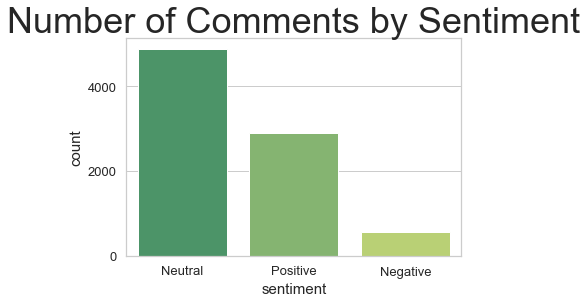

In [182]:
sns.set_style('whitegrid')
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlabel("Sentiment",fontsize=15)
plt.ylabel("Number of Comments", fontsize=15)
sns.countplot(x='sentiment',data=favorita, palette='summer',order = favorita['sentiment'].value_counts().index).set(title="Number of Comments by Sentiment")